In [2]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [3]:
try:
    df = pd.read_csv('../data/ab-test.csv')
    print(df.head())

except Exception as e:
    print(f"Файл не найден: {e}")
    raise

       uid        diff    time group
0   user_1 -103.333333   after  test
1   user_1   -6.000000  before  test
2  user_18  -10.000000   after  test
3  user_18   -3.500000  before  test
4  user_19  -82.333333   after  test


In [4]:
data = df[df['group'] == 'test'][['uid', 'diff']]
# print(data.to_string(index=False))

In [5]:
connection = sqlite3.connect('../data/checking-logs.sqlite')\

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", connection)
list_of_tables = tables.to_string(index=False).split('\n')[1:]

print(f"tables: {' '.join(list_of_tables)}")

for name in list_of_tables:
    query = f"SELECT * FROM {name} LIMIT 5"
    print(f"\ntable {name}")
    print(pd.read_sql(query, connection))
    print()





tables: pageviews   checker deadlines  datamart      test   control

table pageviews
   index      uid                    datetime
0      0  admin_1  2020-04-17 12:01:08.463179
1      1  admin_1  2020-04-17 12:01:23.743946
2      2  admin_3  2020-04-17 12:17:39.287778
3      3  admin_3  2020-04-17 12:17:40.001768
4      4  admin_1  2020-04-17 12:27:30.646665


table   checker
   index    status  success                   timestamp  numTrials   labname  \
0      0  checking        0  2020-04-16 21:12:50.740474          5      None   
1      1     ready        0  2020-04-16 21:12:54.708365          5  code_rvw   
2      2  checking        0  2020-04-16 21:46:47.769088          7      None   
3      3     ready        0  2020-04-16 21:46:48.121217          7     lab02   
4      4  checking        0  2020-04-16 21:53:01.862637          6  code_rvw   

       uid  
0  admin_1  
1  admin_1  
2  admin_1  
3  admin_1  
4  admin_1  


table deadlines
   index     labs   deadlines
0      0   lab


Количество пользователей в анализе: 11

Статистика:
        uid  avg_diff  pageviews  num_commits
0    user_1 -2.713324         28           62
1   user_10 -3.135102         89           20
2   user_14 -6.648700        143           61
3   user_17 -2.591986         47           51
4   user_18 -0.265340          3            5
5   user_19 -4.143351         16          118
6   user_21 -4.004633         10           65
7   user_25 -3.894789        179           79
8   user_28 -3.616410        149           60
9    user_3 -4.405759        317           18
10  user_30 -6.063695          3           34
        avg_diff   pageviews  num_commits
count  11.000000   11.000000    11.000000
mean   -3.771190   89.454545    52.090909
std     1.713936   99.219316    31.957642
min    -6.648700    3.000000     5.000000
25%    -4.274555   13.000000    27.000000
50%    -3.894789   47.000000    60.000000
75%    -2.924213  146.000000    63.500000
max    -0.265340  317.000000   118.000000


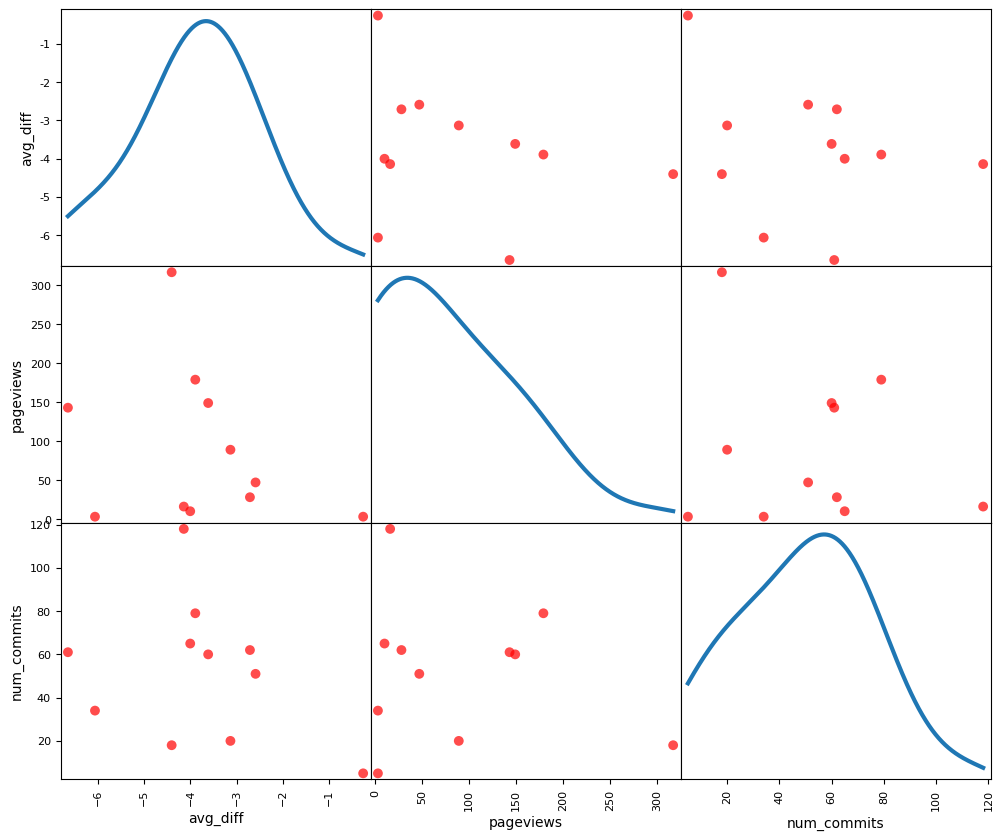

In [6]:
try:
    connect = sqlite3.connect('../data/checking-logs.sqlite')
except Exception as e:
    print("Database file does not exist")
    raise e

avg_diff_query = """
SELECT
    t.uid,
    AVG((strftime('%s', t.first_commit_ts) - d.deadlines) / 86400.0) as avg_diff
FROM test t
JOIN deadlines d ON t.labname = d.labs
WHERE t.labname != 'project1'
GROUP BY t.uid
"""

pageviews_query = """
SELECT
    uid,
    COUNT(*) as pageviews
FROM pageviews
GROUP BY uid
"""

commits_query = """
SELECT
    uid,
    COUNT(*) as num_commits
FROM checker
WHERE labname != 'project1'
GROUP BY uid
"""

try:
    avg_diff_df = pd.read_sql_query(avg_diff_query, connect)
    pageviews_df = pd.read_sql_query(pageviews_query, connect)
    commits_df = pd.read_sql_query(commits_query, connect)
except Exception as e:
    print(f"Unable to make request")
    raise e


# Объединяем все данные
result_df = avg_diff_df.merge(pageviews_df, on='uid', how='inner')
result_df = result_df.merge(commits_df, on='uid', how='inner')

# Создаем scatter matrix
axes = scatter_matrix(result_df[['avg_diff', 'pageviews', 'num_commits']],
                      s=200,  # размер точек
                      diagonal='kde',  # диагональные графики
                      alpha=0.7,
                      color="red",
                      figsize=(12, 10))



# Настройка стиля KDE линий
for ax in axes.flatten():
    for line in ax.get_lines():
        line.set_linewidth(3)

print(f"\nКоличество пользователей в анализе: {len(result_df)}")
print(f"\nСтатистика:")
print(result_df)
print(result_df.describe())

In [7]:
connect.close()

**Вопрос:** Можно ли сказать, что если у пользователя мало просмотров страниц, то, вероятно, у него мало коммитов?</br> **Ответ**: Нет (2,3)

**Вопрос:** Можно ли сказать, что если у пользователя мало просмотров страниц, то, вероятно, у него мало средних разниц между первым коммитом и дедлайном лабораторной работы
небольшая?</br> **Ответ:**  Нет (2,1)

**Вопрос:** Можно ли сказать, что у многих пользователей мало коммитов, а у некоторых много коммитов?</br> **Ответ:** да (3,3)

**Вопрос:** Можно ли сказать, что у многих пользователей средняя разниц небольшая, а у некоторых
большая средняя разниц?</br> **Ответ:** Да (1,1)